# Exp1: to build Variational Auto Encoder for MNIST generation with Keras

## Step1: load the data

In [36]:
import numpy as np
from tensorflow.keras.datasets import mnist

In [37]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [39]:
from tensorflow.keras.utils import to_categorical

num_class = 10

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [40]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Step2: define VAE's model structure

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Reshape,Lambda
from tensorflow.keras.backend import int_shape
from tensorflow.keras import backend as K

z_dim = 2 # the dim of hidden feature spaces
learning_rate = 0.0005
gamma = 1000
batch_size = 64
epochs = 100
# tf.config.experimental_run_functions_eagerly(True) # eager mode: to let Tensor be EagerTensor
tf.compat.v1.disable_eager_execution() # forbid eager execution

In [42]:
class VAE():
    def __init__(self,z_dim):
        self.z_dim = z_dim
        self._build_model()
    def _build_model(self):
        # encoder
        self._build_encoder()
        # decoder
        self._build_decoder()
        # full model
        self.model_input_layer = self.encoder_input_layer
        self.model_output_layer = self.decoder(self.encoder_output_layer)
        self.model = Model(self.model_input_layer,self.model_output_layer)
    def _build_encoder(self):
        # input layer
        self.encoder_input_layer = Input(shape=(28,28,1), name = 'encoder_input')
        # conv layer 1
        x = Conv2D(
            filters = 32, kernel_size = (3,3),
            strides = 1, padding = 'same'
        )(self.encoder_input_layer)
        x = LeakyReLU()(x)
        # conv layer 2
        x = Conv2D(
            filters = 64, kernel_size = (3,3),
            strides = 2, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # conv layer 3
        x = Conv2D(
            filters = 64, kernel_size = (3,3),
            strides = 2, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # conv layer 4
        x = Conv2D(
            filters = 64, kernel_size = (3,3),
            strides = 1, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # flatten layer
        self.unflatten_shape = int_shape(x)[1:]
        x = Flatten()(x)
        self.flatten_shape = x.shape[1] # after flatten layer, x.shape = [None,flatten_size]
        # dense layer 1 for mu
        self.mu_layer = Dense(
            units = self.z_dim, name = 'mu'
        )(x)
        # dense layer 2 for log var
        self.logvar_layer = Dense(
            units = self.z_dim, name = 'logvar'
        )(x)
        # output layer 1 for mu and log var
        self.mu_logvar_output_layer = Model(self.encoder_input_layer,(self.mu_layer,self.logvar_layer))
        # output layer 2 for z
        def sampleLatentZ(args):
            mu,log_var = args
            epsilon = K.random_normal(shape=K.shape(mu),mean=0.,stddev=1.) # sample from standard norm
            return mu + K.exp(log_var/2) * epsilon

        self.encoder_output_layer = Lambda(
            sampleLatentZ, name = 'encoder_output'
        )([self.mu_layer,self.logvar_layer])

        self.encoder = Model(self.encoder_input_layer,self.encoder_output_layer)
    def _build_decoder(self):
        # input layer
        self.decoder_input_layer = Input(shape=(self.z_dim,), name = 'decoder_input')
        # dense layer
        x = Dense(
            units = self.flatten_shape,
        )(self.decoder_input_layer)
        x = Reshape(target_shape=self.unflatten_shape)(x)
        # conv-T layer 1
        x = Conv2DTranspose(
            filters = 64, kernel_size = (3,3),
            strides = 1, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # conv-T layer 2
        x = Conv2DTranspose(
            filters = 64, kernel_size = (3,3),
            strides = 2, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # conv-T layer 3
        x = Conv2DTranspose(
            filters = 32, kernel_size = (3,3),
            strides = 2, padding = 'same'
        )(x)
        x = LeakyReLU()(x)
        # output layer
        self.decoder_output_layer = Conv2DTranspose(
            filters = 1, kernel_size = (3,3),
            strides = 1, padding = 'same',
            activation = 'sigmoid',
            name = 'decoder_output'
        )(x)

        self.decoder = Model(self.decoder_input_layer,self.decoder_output_layer) 
    def encoder_summary(self):
        self.encoder.summary()
    def decoder_summary(self):
        self.decoder.summary()
    def compile_model(self,learning_rate,gamma):
        from tensorflow.keras.optimizers import Adam

        optimizer = Adam(lr=learning_rate)
        
        def rmse_loss(y_true,y_pred):
            return K.mean( # the rmse among pixel-shape (28,28,1)
                K.square(y_true-y_pred), axis = [1,2,3] 
            )
        
        def kl_loss(y_true,y_pred):
            return -0.5 * K.sum( # Dkl[N(mu,logvar) || N(0,1)]
                1. + self.logvar_layer - K.square(self.mu_layer) - K.exp(self.logvar_layer), axis = 1
            )

        def vae_loss(y_true,y_pred): # gamma is the weight for rmse_loss
            return gamma * rmse_loss(y_true,y_pred) + kl_loss(y_true,y_pred)

        self.model.compile(
            optimizer = optimizer,
            loss = vae_loss,
            metrics = [rmse_loss,kl_loss]
        )
    def fit_model(self,x_train,batch_size,epochs):
        self.model.fit(
            x = x_train, y = x_train,
            batch_size = batch_size, epochs = epochs, shuffle = True
        )

In [43]:
vae = VAE(z_dim)
vae.encoder_summary()
vae.decoder_summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_32 (LeakyReLU)      (None, 28, 28, 32)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 14, 14, 64)   18496       leaky_re_lu_32[0][0]             
___________________________________________________________________________________________

In [44]:
vae.compile_model(learning_rate,gamma)

In [45]:
vae.fit_model(x_train[np.random.choice(range(60000),size=20000)],batch_size,epochs)

Train on 20000 samples
Epoch 1/100
20000/20000 [==============================] - 35s 2ms/sample - loss: 73.7415 - rmse_loss: 0.0708 - kl_loss: 2.9869
Epoch 2/100
20000/20000 [==============================] - 35s 2ms/sample - loss: 57.2161 - rmse_loss: 0.0542 - kl_loss: 3.0131
Epoch 3/100
20000/20000 [==============================] - 36s 2ms/sample - loss: 55.0899 - rmse_loss: 0.0517 - kl_loss: 3.3476
Epoch 4/100
20000/20000 [==============================] - 35s 2ms/sample - loss: 53.6862 - rmse_loss: 0.0501 - kl_loss: 3.6122
Epoch 5/100
20000/20000 [==============================] - 35s 2ms/sample - loss: 52.6953 - rmse_loss: 0.0490 - kl_loss: 3.7241
Epoch 6/100
20000/20000 [==============================] - 33s 2ms/sample - loss: 52.0836 - rmse_loss: 0.0482 - kl_loss: 3.8619
Epoch 7/100
20000/20000 [==============================] - 33s 2ms/sample - loss: 51.5780 - rmse_loss: 0.0476 - kl_loss: 3.9627
Epoch 8/100
20000/20000 [==============================] - 33s 2ms/sample - loss:

## Step7: show the generation effect

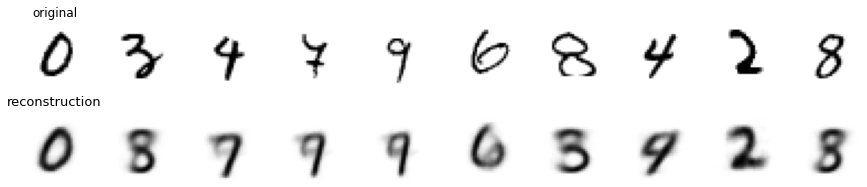

In [46]:
import matplotlib.pyplot as plt
n_to_show = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images) # encode the example images to latent space
reconst_images = vae.decoder.predict(z_points) # reconstruct the example images from latent space

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    if i == 0:
        ax.set_title('original')
        ax.text(0.5, -0.35, 'reconstruction', fontsize=13, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

## Step8: show the latent space distribution

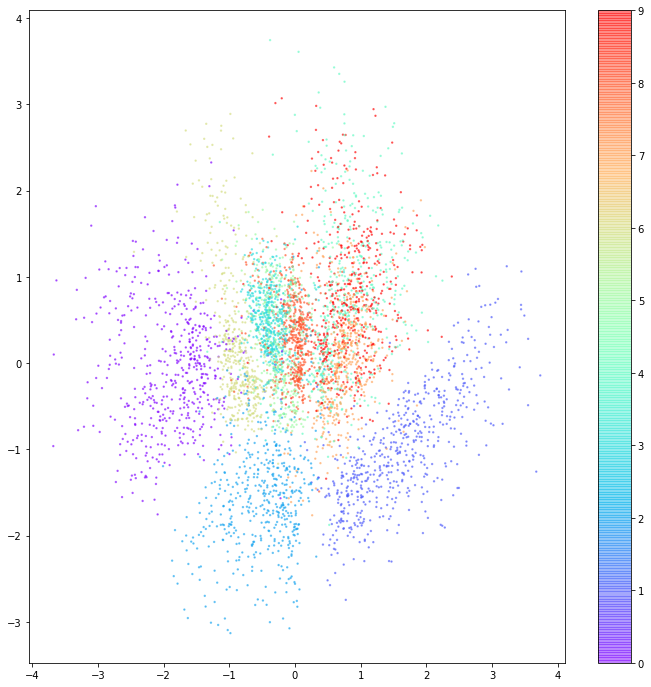

In [47]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], 
            cmap ='rainbow' , c = example_labels, alpha=0.5, s=2)
plt.colorbar()
plt.show()

$\Rightarrow$ The latent space is symmetric centered at (0,0)

## Step9: show the new generation effect

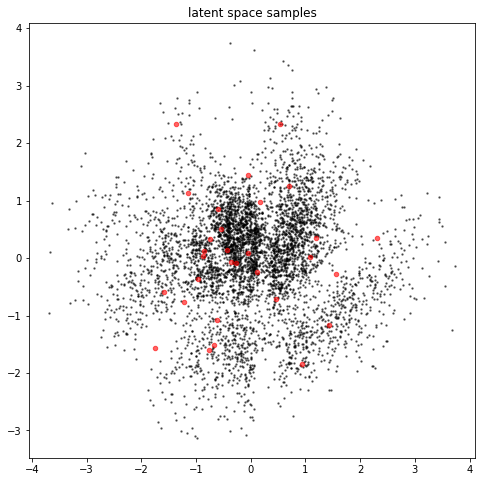

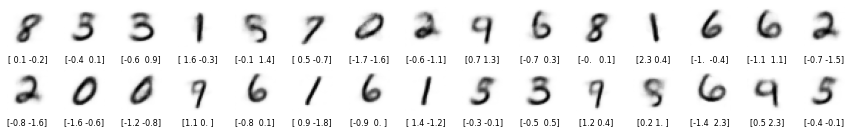

In [48]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
# plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.title("latent space samples")
plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=0.6, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')